In [1]:
import tensorflow as tf
from PIL import Image
import numpy as np
import cv2

In [2]:
from superglue.keypoint_extractors import SuperPointExtractor, Keypoints
from superglue.datasets import create_training_image_pair_sampler_fn

In [3]:
extractor = SuperPointExtractor("/home/mkk/Transferências/sp_v5")

In [140]:
image_size=(512, 512)

sample_fn = create_training_image_pair_sampler_fn(
    extractor=extractor,
    image_size=image_size,
    reprojection_threshold = 5, 
    num_matches=512,
)

In [141]:
image = Image.open("/home/mkk/Downloads/a.jpg")
image_np = np.array(image)

In [146]:
input_image = np.array(image.resize(image_size))
transformed_image, (features, labels) = sample_fn(image_np)

tf.Tensor(408, shape=(), dtype=int32) tf.Tensor(666, shape=(), dtype=int32)


In [147]:
fa, ka, fb, kb = features

In [148]:
cv_ka = Keypoints.convert_numpy_keypoints_to_cv(ka.numpy() * np.array([[512, 512]]))
cv_kb = Keypoints.convert_numpy_keypoints_to_cv(kb.numpy() * np.array([[512, 512]]))

In [149]:
np.where(np.diff(labels[:, -1]) == 1)[0]

array([407])

In [150]:
img_with_keypoints = cv2.drawKeypoints(
    input_image, 
    cv_ka, 
    outImage=None, color=(0, 0, 255), 
    flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS
)

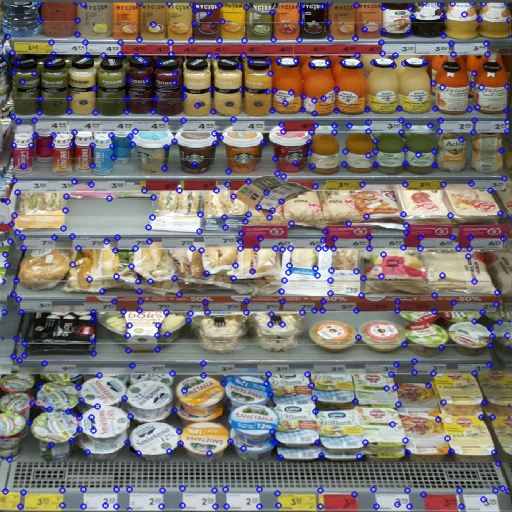

In [151]:
Image.fromarray(img_with_keypoints)

In [152]:
img_with_keypoints = cv2.drawKeypoints(
    transformed_image.numpy().astype("uint8"), 
    cv_kb, 
    outImage=None, color=(0, 0, 255), 
    flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS
)

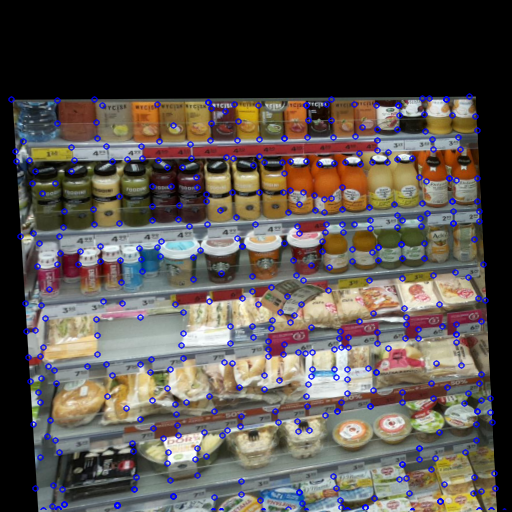

In [153]:
Image.fromarray(img_with_keypoints)

In [154]:
np.where(np.diff(labels[:, -1]) == 1)[0][0]

407

In [158]:
start = 450
num_matches = 512
img_with_keypoints = cv2.drawMatches(
    input_image, cv_ka[start:num_matches],
    transformed_image.numpy().astype("uint8"), cv_kb[start:num_matches],
    [cv2.DMatch(_queryIdx=i, _trainIdx=i, _distance=0) for i in range(num_matches - start)], outImg=None
)

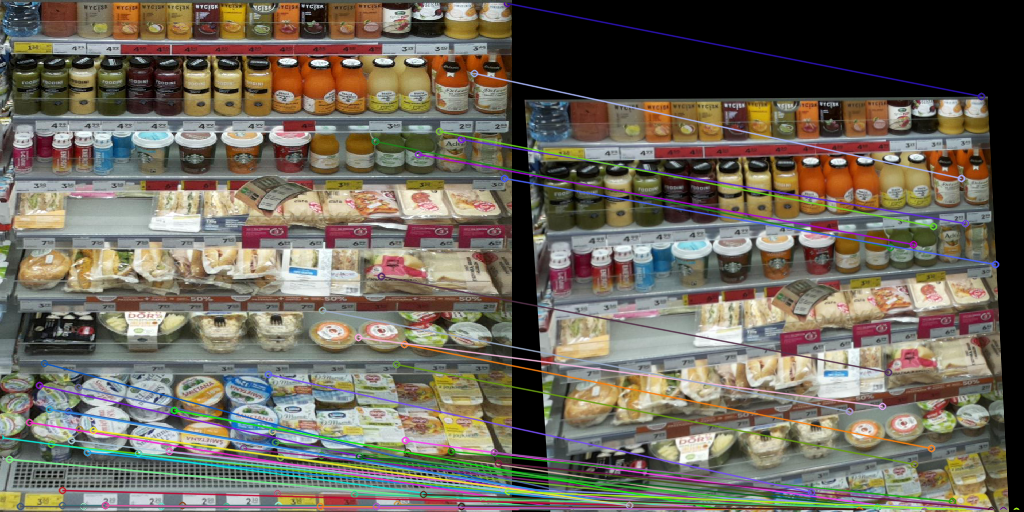

In [159]:
Image.fromarray(img_with_keypoints)

In [11]:
from superglue.homographies import homographic_augmentation, invert_homography, warp_points

In [12]:
data = {"image": image_np, "keypoints": keypoints.keypoints}
transformed_data = homographic_augmentation(data, add_homography=True, params={}, valid_border_margin=0)

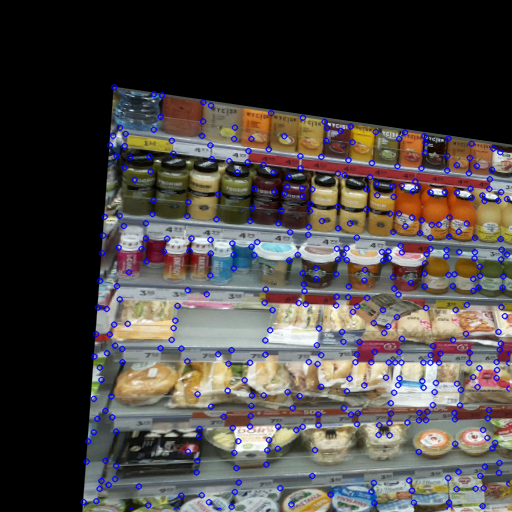

In [14]:
img_with_keypoints = cv2.drawKeypoints(
    transformed_data['image'].numpy(), 
    Keypoints.convert_numpy_keypoints_to_cv(transformed_data['keypoints'].numpy()), 
    outImage=None, color=(0, 0, 255), flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS
)
Image.fromarray(img_with_keypoints)

In [15]:
# Image.fromarray(transformed_data['image'].numpy())
keypoints2 = extractor.extract(transformed_data['image'])

In [16]:
len(keypoints2.keypoints)

383

In [18]:
img_with_keypoints = cv2.drawKeypoints(
    transformed_data['image'].numpy(), 
    keypoints2.cv_keypoints, outImage=None, color=(0, 0, 255), 
    flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS
)

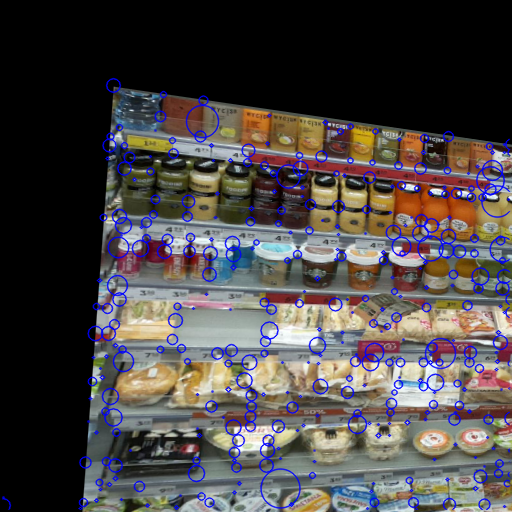

In [19]:
Image.fromarray(img_with_keypoints)

In [21]:
# transformed_data['keypoints']

In [22]:
import tensorflow as tf

In [23]:
inv_homography = invert_homography(tf.expand_dims(transformed_data['homography'], 0))

In [24]:
reprojected_points = warp_points(keypoints2.numpy_keypoints(), inv_homography[0])

In [25]:
img_with_keypoints = cv2.drawKeypoints(
    image_np, Keypoints.convert_numpy_keypoints_to_cv(reprojected_points.numpy()), outImage=None, color=(0, 0, 255), 
    flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS
)

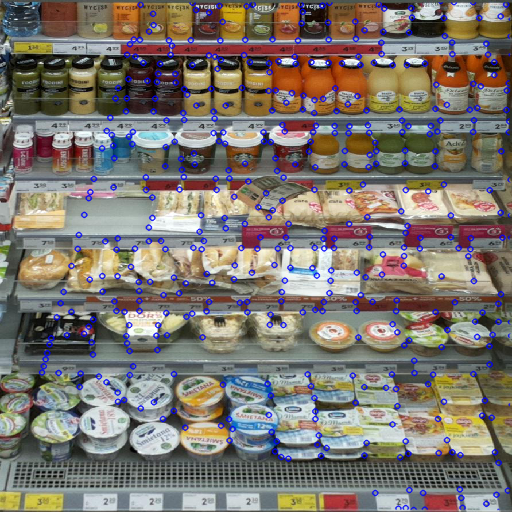

In [26]:
Image.fromarray(img_with_keypoints)

In [27]:
from scipy.spatial import distance_matrix

In [28]:
match_matrix = distance_matrix(keypoints.numpy_keypoints(), reprojected_points.numpy())

In [29]:
k1 = keypoints.numpy_keypoints()
k2 = reprojected_points.numpy()
dmat = np.sqrt(np.maximum(np.sum(k1**2, -1, keepdims=True) - 2 * k1 @ k2.T + np.sum(k2**2, -1, keepdims=True).T, 0.0))
dmat

array([[617.74334488, 341.39749783, 378.20879802, ..., 416.53777425,
        416.7183407 ,  94.4413001 ],
       [389.50625265, 207.36549228, 208.37223432, ...,  46.64776694,
        386.04002118, 367.84366476],
       [597.03879256, 329.24019474, 364.82594476, ..., 417.96438564,
        390.39203647, 104.79480959],
       ...,
       [436.408482  , 166.70617466, 191.11268336, ...,  87.54186847,
        359.10786675, 242.13846905],
       [456.64731496, 166.19760045, 204.19691059, ..., 250.80344856,
        287.25941381,  98.73088603],
       [495.17343283, 208.72523814, 239.88747082, ..., 154.45702794,
        393.21935931, 195.92752592]])

In [30]:
np.max(np.abs(match_matrix - dmat))

0.063048579347359

In [31]:
dmat.min(-1) < 5 

array([False,  True, False,  True, False,  True,  True,  True, False,
        True,  True, False,  True, False,  True,  True,  True,  True,
        True,  True,  True,  True, False, False,  True, False,  True,
        True, False,  True, False, False, False,  True,  True,  True,
        True, False,  True, False,  True,  True, False,  True, False,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True, False,  True,  True, False,  True,  True,  True,  True,
        True,  True,  True, False,  True,  True,  True,  True, False,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True, False,  True,  True,  True,  True,  True, False,
        True,  True,  True,  True, False,  True,  True,  True,  True,
        True,  True, False,  True,  True,  True,  True,  True,  True,
       False,  True, False,  True,  True,  True,  True, False, False,
        True,  True,  True,  True,  True, False, False, False, False,
        True,  True,